# e2e examples

In this notebook we will show how to generate a lognormal mock, apply and assess quality of reconstruction. Look first at the notebook basic_examples.ipynb that introduces *pyrecon*.
We also use pypower; look at https://github.com/cosmodesi/pypower/blob/main/nb/basic_examples.ipynb to understand the pypower API.

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

# For mockfactory installation, see https://github.com/cosmodesi/mockfactory
from mockfactory import EulerianLinearMock, LagrangianLinearMock, utils, setup_logging
# For cosmoprimo installation, see https://cosmoprimo.readthedocs.io/en/latest/user/building.html
from cosmoprimo.fiducial import DESI

from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, PlaneParallelFFTReconstruction
# For pypower installation, see https://pypower.readthedocs.io/en/latest/user/building.html
from pypower import CatalogFFTPower
from pyrecon.metrics import MeshFFTCorrelator, MeshFFTPropagator, CatalogMesh

# Set up logging
setup_logging()
z = 1.
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate

## Lognormal mock in box

In [2]:
bias, nbar, nmesh, boxsize, boxcenter, los = 2., 1e-3, 200, 1000., 0., 'x'

mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
mesh_real = mock.mesh_delta_k.c2r() + 1.
# This is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias - 1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
mock.set_rsd(f=f, los=los)
data = mock.to_catalog()
offset = boxcenter - boxsize / 2.
data['Position'] = (data['Position'] - offset) % boxsize + offset
print(mesh_real.value.std())

[000003.08] [0/1] 04-11 21:58  LagrangianLinearMock      INFO     White noise generated.
[000005.44] [0/1] 04-11 21:58  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 1000661.
[000006.41] [0/1] 04-11 21:58  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.
0.9969937


## Run reconstruction

In [3]:
#ReconstructionAlgorithm = MultiGridReconstruction  # choose your algorithm
ReconstructionAlgorithm = IterativeFFTReconstruction
#ReconstructionAlgorithm = PlaneParallelFFTReconstruction
recon = ReconstructionAlgorithm(f=f, bias=bias, los=los, data_positions=data['Position'], nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, fft_plan='estimate', wrap=True)

data['Position_rec'] = recon.read_shifted_positions(data['Position'], field='disp+rsd')

# We need to create randoms, to shift them
from mockfactory.make_survey import RandomBoxCatalog
randoms = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=44)
randoms['Position_rec'] = recon.read_shifted_positions(randoms['Position'], field='disp')

[000008.31] [0/1] 04-11 21:58  IterativeFFTReconstruction INFO     Using mesh with nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.].
[000008.37] [0/1] 04-11 21:58  IterativeFFTReconstruction INFO     Slab 0 ~ 4194304 / 1000661.
[000008.81] [0/1] 04-11 21:58  IterativeFFTReconstruction INFO     Painted 1000661 out of 1000661 objects to mesh.
[000009.46] [0/1] 04-11 21:58  IterativeFFTReconstruction INFO     Running iteration 0.
[000010.21] [0/1] 04-11 21:58  IterativeFFTReconstruction INFO     Running iteration 1.
[000010.97] [0/1] 04-11 21:58  IterativeFFTReconstruction INFO     Running iteration 2.


## Estimate power spectrum multipoles

[000015.81] [0/1] 04-11 21:58  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000015.86] [0/1] 04-11 21:58  CatalogMesh               INFO     Slab 0 ~ 4194304 / 1000661.
[000016.28] [0/1] 04-11 21:58  CatalogMesh               INFO     Painted 1000661 out of 1000661 objects to mesh.
[000016.28] [0/1] 04-11 21:58  CatalogMesh               INFO     Running interlacing at order 2.
[000016.56] [0/1] 04-11 21:58  CatalogMesh               INFO     Slab 0 ~ 4194304 / 1000661.
[000016.97] [0/1] 04-11 21:58  CatalogMesh               INFO     Painted 1000661 out of 1000661 objects to mesh.
[000017.62] [0/1] 04-11 21:58  CatalogFFTPower           INFO     Done painting catalog 1 to mesh.
[000017.62] [0/1] 04-11 21:58  CatalogFFTPower           INFO     Using 77 k-bins between 0.010 and 0.395.
[000017.62] [0/1] 04-11 21:58  CatalogFFTPower           INFO     Meshes prepared in el

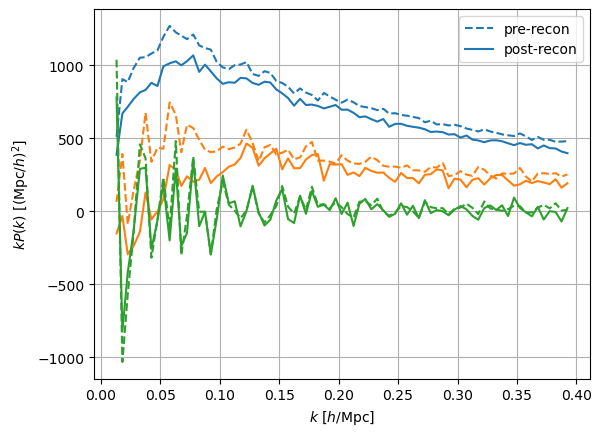

In [4]:
kedges = np.arange(0.01, 0.4, 0.005)

poles = CatalogFFTPower(data_positions1=data['Position'], boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='cic',
                        interlacing=2, ells=(0, 2, 4), los=los, edges=kedges, position_type='pos').poles

poles_recon = CatalogFFTPower(data_positions1=data['Position_rec'], shifted_positions1=randoms['Position_rec'],
                              boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='cic', interlacing=2, ells=(0, 2, 4), los=los, edges=kedges, position_type='pos').poles

ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles.k*poles(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='--', label='pre-recon' if ill == 0 else None)
    ax.plot(poles_recon.k, poles_recon.k*poles_recon(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='-', label='post-recon' if ill == 0 else None)
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

## Compute correlator to assess reconstruction

In [5]:
mesh_recon = CatalogMesh(data['Position_rec'], shifted_positions=randoms['Position_rec'],
                         boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='tsc',
                         interlacing=3, position_type='pos')

muedges = np.linspace(-1., 1., 5)
# WARNING: input meshes (if not CatalogMesh) should be normalized as 1 + delta or nbar*(1 + delta);
# this is e.g. the case of "mesh_real" in this example
correlator = MeshFFTCorrelator(mesh_recon, mesh_real, edges=(kedges, muedges), los=los)

[000023.86] [0/1] 04-11 21:59  MeshFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000023.91] [0/1] 04-11 21:59  CatalogMesh               INFO     Slab 0 ~ 4194304 / 1000661.
[000024.37] [0/1] 04-11 21:59  CatalogMesh               INFO     Painted 1000661 out of 1000661 objects to mesh.
[000024.39] [0/1] 04-11 21:59  CatalogMesh               INFO     Slab 0 ~ 4194304 / 1000000.
[000025.11] [0/1] 04-11 21:59  CatalogMesh               INFO     Painted 1000000 out of 1000000 objects to mesh.
[000025.11] [0/1] 04-11 21:59  CatalogMesh               INFO     Running interlacing at order 3.
[000025.38] [0/1] 04-11 21:59  CatalogMesh               INFO     Slab 0 ~ 4194304 / 1000661.
[000025.85] [0/1] 04-11 21:59  CatalogMesh               INFO     Painted 1000661 out of 1000661 objects to mesh.
[000025.86] [0/1] 04-11 21:59  CatalogMesh               INFO     Slab 0 ~ 4194304 / 

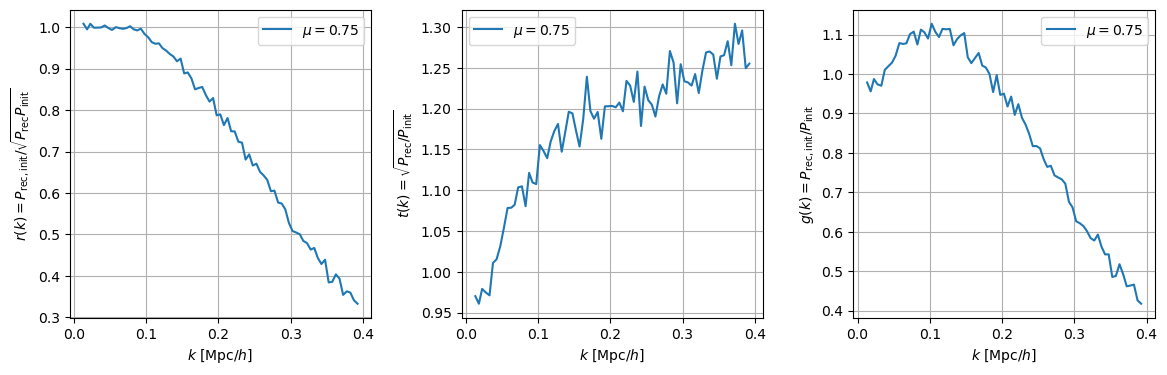

In [6]:
propagator = correlator.to_propagator(growth=bias)
transfer = correlator.to_transfer(growth=bias)
fig, lax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for imu, mu in enumerate(correlator.muavg[3:]):
    lax[0].plot(*correlator(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
    lax[1].plot(*transfer(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
    lax[2].plot(*propagator(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$\mathrm{Mpc}/h$]')
lax[0].set_ylabel(r'$r(k) = P_{\mathrm{rec},\mathrm{init}}/\sqrt{P_{\mathrm{rec}}P_{\mathrm{init}}}$')
lax[1].set_ylabel(r'$t(k) = \sqrt{P_{\mathrm{rec}}/P_{\mathrm{init}}}$')
lax[2].set_ylabel(r'$g(k) = P_{\mathrm{rec},\mathrm{init}}/P_{\mathrm{init}}$')
plt.show()

In [7]:
# You can save the result (similarly for MeshFFTCorrelator and MeshFFTTransfer)
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    propagator.save(fn)
    # And reload the result
    propagator = MeshFFTPropagator.load(fn)
    print(propagator.edges[0])

# You can also export correlator (similarly for MeshFFTPropagator and MeshFFTTransfer) as .txt
# WARNING: this does not save all attributes, so there is not load_txt method
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.txt')
    # See get_corr() for all arguments
    correlator.save_txt(fn, header=['data_file = data.fits', 'shifted_file = shifted.fits'])
    with open(fn, 'r') as file:
        for iline in range(30):
            print(next(file)[:-1])
    tmp = np.loadtxt(fn, unpack=True)
    assert np.allclose(tmp[5], correlator().flat, equal_nan=True)

[000036.94] [0/1] 04-11 21:59  MeshFFTPropagator         INFO     Saving /tmp/tmpa9bcbail/tmp.npy.
[000036.94] [0/1] 04-11 21:59  MeshFFTPropagator         INFO     Loading /tmp/tmpa9bcbail/tmp.npy.
[0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065
 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12  0.125
 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175 0.18  0.185
 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235 0.24  0.245
 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295 0.3   0.305
 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355 0.36  0.365
 0.37  0.375 0.38  0.385 0.39  0.395]
[000036.94] [0/1] 04-11 21:59  MeshFFTCorrelator         INFO     Saving /tmp/tmp0x5mnzmi/tmp.txt.
# data_file = data.fits
# shifted_file = shifted.fits
# los_type = global
# los = [1.000000000000e+00 0.000000000000e+00 0.000000000000e+00]
# nmesh = [200 200 200]
# boxsize = [1.000000000000e+03 1.000000000000e+03 1.00000000

## MPI
**pyrecon** and **pypower** are MPI-parallelized. Let's start from initial conditions and pre-recon catalogs saved on disk.

In [8]:
# Save above initial conditions and (reconstructed) catalogs
base_dir = '_tests'
utils.mkdir(base_dir)

init_fn = os.path.join(base_dir, 'initial_conditions.npy')
np.save(init_fn, mesh_real.value)

data_fn = os.path.join(base_dir, 'data.fits')
randoms_fn = os.path.join(base_dir, 'randoms.fits')
data.write(data_fn)
randoms.write(randoms_fn)

[000037.28] [0/1] 04-11 21:59  FileStack                 INFO     Writing _tests/data.fits.
[000037.80] [0/1] 04-11 21:59  FileStack                 INFO     Writing _tests/randoms.fits.


In [9]:
%%file '_tests/script.py'

import os

import numpy as np

from cosmoprimo.fiducial import DESI
from pyrecon import IterativeFFTReconstruction
from pyrecon.metrics import MeshFFTCorrelator, MeshFFTPropagator, ArrayMesh, CatalogMesh
from pypower import mpi, setup_logging

# Set up logging
setup_logging()

base_dir = '_tests'
init_fn = os.path.join(base_dir, 'initial_conditions.npy')
data_fn = os.path.join(base_dir, 'data.fits')

cosmo = DESI()
z = 1.
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate
bias, nbar, nmesh, boxsize, boxcenter, los = 2.0, 1e-3, 200, 1000., 0., 'x'

mpicomm = mpi.COMM_WORLD
kedges = np.arange(0.01, 0.4, 0.005)
muedges = np.linspace(-1., 1., 5)

# Load mesh
mpiroot = 0
if mpicomm.rank == mpiroot:
    mesh_init = np.load(init_fn)
else:
    mesh_init = None
mesh_init = ArrayMesh(mesh_init, boxsize, mpiroot=mpiroot, mpicomm=mpicomm)

'''
# Read input catalogs, scattering on all MPI ranks
def read(fn, columns=['Position'], ext=1):
    #import fitsio
    #gsize = fitsio.FITS(fn)[ext].get_nrows()
    #start, stop = mpicomm.rank * gsize // mpicomm.size, (mpicomm.rank + 1) * gsize // mpicomm.size
    #tmp = fitsio.read(fn, ext=ext, columns=[column], rows=range(start, stop))
    #return {column: tmp[column] for column in columns}
'''
# Here we just use mockfactory's Catalog that has read()
from mockfactory import Catalog, RandomBoxCatalog
    
data = Catalog.read(data_fn, mpicomm=mpicomm)

# First, run reconstruction
#ReconstructionAlgorithm = MultiGridReconstruction # choose your algorithm
ReconstructionAlgorithm = IterativeFFTReconstruction
#ReconstructionAlgorithm = PlaneParallelFFTReconstruction
recon = ReconstructionAlgorithm(f=f, bias=bias, los=los, data_positions=data['Position'], nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, fft_plan='estimate', wrap=True)
data['Position_rec'] = recon.read_shifted_positions(data['Position'], field='disp+rsd')
# We need to create randoms, to shift them
randoms = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=44)
randoms['Position_rec'] = recon.read_shifted_positions(randoms['Position'], field='disp')

# Then, compute propagator
mesh_recon = CatalogMesh(data['Position_rec'], shifted_positions=randoms['Position_rec'],
                         boxsize=boxsize, boxcenter=boxcenter, nmesh=mesh_init.pm.Nmesh, resampler='tsc',
                         interlacing=3, position_type='pos', mpicomm=mpicomm, mpiroot=None)
muedges = np.linspace(-1., 1., 5)
correlator = MeshFFTCorrelator(mesh_recon, mesh_init, edges=(kedges, muedges), los=los)

fn = os.path.join(base_dir, 'correlator.npy')
correlator.save(fn)

Overwriting _tests/script.py


In [10]:
%%bash
mpiexec -np 4 python _tests/script.py

[000002.43]  04-11 21:59  IterativeFFTReconstruction   INFO     Using mesh with nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.].
[000002.48]  04-11 21:59  IterativeFFTReconstruction   INFO     Slab 0 ~ 4194304 / 1000661.
[000002.89]  04-11 21:59  IterativeFFTReconstruction   INFO     Painted 1000661 out of 1000661 objects to mesh.
[000003.57]  04-11 21:59  IterativeFFTReconstruction   INFO     Running iteration 0.
[000004.33]  04-11 21:59  IterativeFFTReconstruction   INFO     Running iteration 1.
[000005.08]  04-11 21:59  IterativeFFTReconstruction   INFO     Running iteration 2.
[000010.04]  04-11 21:59  MeshFFTPower                 INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000010.09]  04-11 21:59  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 1000661.
[000010.57]  04-11 21:59  CatalogMesh                  INFO     Painted 1000661 out of 1000661 objects to 

In [11]:
!ls -l _tests

/local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


total 148576
-rw-r--r-- 1 adematti idphp    57496 avril 11 21:59 correlator.npy
-rw-r--r-- 1 adematti idphp 72054720 avril 11 21:59 data.fits
-rw-r--r-- 1 adematti idphp 32000128 avril 11 21:59 initial_conditions.npy
-rw-r--r-- 1 adematti idphp 48006720 avril 11 21:59 randoms.fits
-rw-r--r-- 1 adematti idphp     2692 avril 11 21:59 script.py


[000073.87] [0/1] 04-11 21:59  MeshFFTCorrelator         INFO     Loading _tests/correlator.npy.


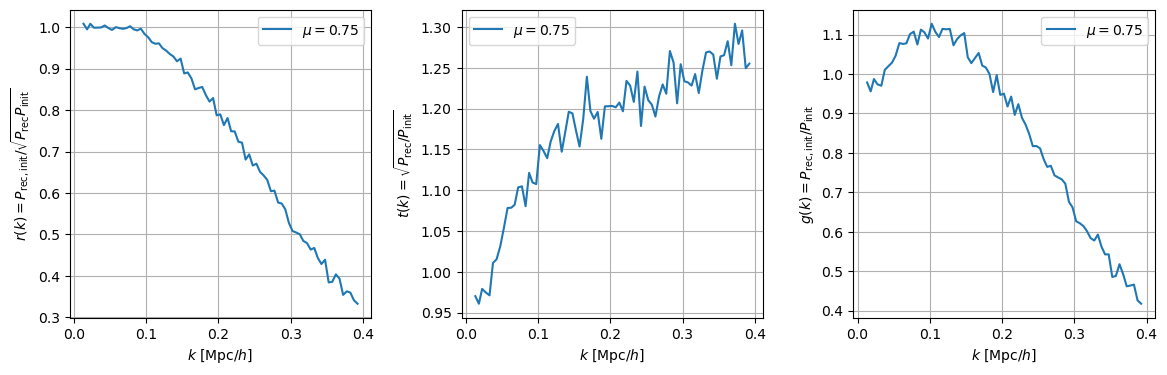

In [12]:
fn = os.path.join(base_dir, 'correlator.npy')
correlator_mpi = MeshFFTCorrelator.load(fn)

# We have the same correlator as in the non-MPI case!
assert np.allclose(correlator_mpi.ratio, correlator.ratio)

correlator = correlator_mpi
propagator = correlator.to_propagator(growth=bias)
transfer = correlator.to_transfer(growth=bias)
fig, lax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for imu, mu in enumerate(correlator.muavg[3:]):
    lax[0].plot(*correlator(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
    lax[1].plot(*transfer(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
    lax[2].plot(*propagator(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$\mathrm{Mpc}/h$]')
lax[0].set_ylabel(r'$r(k) = P_{\mathrm{rec},\mathrm{init}}/\sqrt{P_{\mathrm{rec}}P_{\mathrm{init}}}$')
lax[1].set_ylabel(r'$t(k) = \sqrt{P_{\mathrm{rec}}/P_{\mathrm{init}}}$')
lax[2].set_ylabel(r'$g(k) = P_{\mathrm{rec},\mathrm{init}}/P_{\mathrm{init}}$')
plt.show()